In [2]:
!unzip brain_tumor_dataset.zip > /dev/null

In [3]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import plotly.express as px
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split


In [4]:
#tranform the images

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
#create datasets using ImageFolder

training_data = datasets.ImageFolder(root='Training', transform=train_transforms)

testing_data = datasets.ImageFolder(root='Testing', transform=test_transforms)

(512, 512, 3)


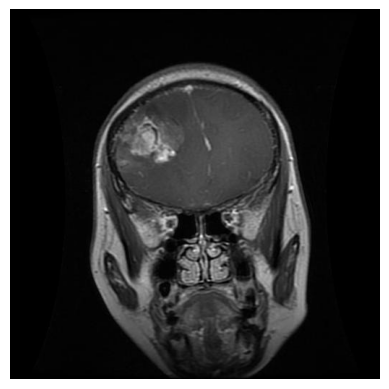

In [6]:
#print a single image before transforming

file = training_data.imgs[0]
img = mpimg.imread(file[0])
print(img.shape)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

(256, 256, 1)
Label: Glioma


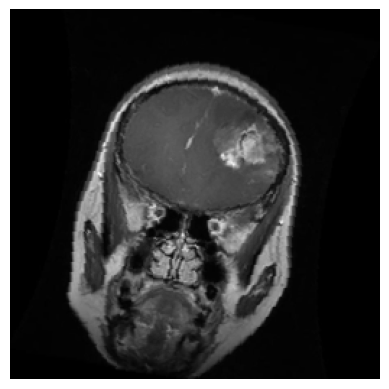

In [7]:
#print a single image from the training dataset

img, label = training_data[0]
img = img.numpy().transpose((1, 2, 0))
print(img.shape)
categories = ['Glioma', 'Meningioma', 'No_tumor', 'Pituitary']
print(f'Label: {categories[label]}')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# visualize the training data using a plotly bar chart

labels_counts = {}
for label in training_data.targets:
    if label in labels_counts:
        labels_counts[label] += 1
    else:
        labels_counts[label] = 1

labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
labels_counts = {labels[key]: value for key, value in labels_counts.items()}

fig = px.bar(x=list(labels_counts.keys()), y=list(labels_counts.values()), labels={'x': 'Labels', 'y': 'Counts'}, title='Training Data Labels Counts', color=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
fig.show()

In [9]:
# visualize the testing data using a plotly bar chart

labels_counts = {}
for label in testing_data.targets:
    if label in labels_counts:
        labels_counts[label] += 1
    else:
        labels_counts[label] = 1

labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
labels_counts = {labels[key]: value for key, value in labels_counts.items()}

fig = px.bar(x=list(labels_counts.keys()), y=list(labels_counts.values()), labels={'x': 'Labels', 'y': 'Counts'}, title='Testing Data Labels Counts', color=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
fig.show()

In [10]:
# split the Trainining data into train and validation

train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)

In [11]:
# create dataloaders using DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)

In [12]:
# Batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f'Batch of images: {images.size()}')
print(f'Batch of labels: {labels}')

Batch of images: torch.Size([32, 1, 256, 256])
Batch of labels: tensor([2, 3, 3, 1, 0, 3, 0, 3, 2, 1, 2, 1, 0, 3, 2, 3, 0, 2, 1, 1, 3, 3, 3, 3,
        0, 2, 3, 3, 1, 1, 3, 3])


In [35]:
# create CNN model

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(f'First conv layer: {x.size()}')
        x = self.pool(F.relu(self.conv2(x)))
        #print(f'Second conv layer: {x.size()}')
        x = self.pool(F.relu(self.conv3(x)))
        #print(f'Third conv layer: {x.size()}')
        x = self.pool(F.relu(self.conv4(x)))
        #print(f'Fourth conv layer: {x.size()}')
        x = self.pool(F.relu(self.conv5(x)))
        #print(f'Fifth conv layer: {x.size()}')
        x = self.pool(F.relu(self.conv6(x)))
        #print(f'Sixth conv layer: {x.size()}')
        x = x.view(-1, 256 * 4 * 4)
        #print(f'Flatten layer: {x.size()}')
        x = self.dropout(x)
        #print(f'After dropout: {x.size()}')
        x = F.relu(self.fc1(x))
        #print(f'First FC layer: {x.size()}')
        x = self.dropout(x)
        #print(f'After dropout: {x.size()}')
        x = self.fc2(x)
        #print(f'Second FC layer: {x.size()}')
        return x

    def predict(self, x):
        return self.forward(x).argmax(dim=1)



In [36]:
# create loss function and optimizer

import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda


In [37]:
from datetime import datetime
from sklearn.metrics import roc_auc_score
import seaborn as sns

def train_model(model, loss_function, optimizer, num_epochs):
    epoch_metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'roc_auc': []
        }
    for epoch in range(num_epochs):
        start = datetime.now()
        metrics = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'roc_auc': []
        }
        model.train()

        for img, label in train_loader:
            img, label = img.to(device), label.to(device)

            preds = model(img)

            loss = loss_function(preds, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            metrics['train_loss'].append(loss.item())
            metrics['train_accuracy'].append((preds.argmax(1) == label).float().mean().item())

        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.inference_mode():
            for img, label in val_loader:
                img, label = img.to(device), label.to(device)

                preds = model(img)

                loss = loss_function(preds, label)

                metrics['val_loss'].append(loss.item())
                metrics['val_accuracy'].append((preds.argmax(1) == label).float().mean().item())

                all_preds.extend(preds.argmax(1).cpu().numpy())
                all_labels.extend(label.cpu().numpy())
                all_probs.extend(F.softmax(preds, dim=1).cpu().numpy())

        roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        metrics['roc_auc'].append(roc_auc)

        epoch_train_loss = np.mean(metrics['train_loss'])
        epoch_metrics['train_loss'].append(epoch_train_loss)
        epoch_val_loss = np.mean(metrics['val_loss'])
        epoch_metrics['val_loss'].append(epoch_val_loss)
        epoch_train_accuracy = np.mean(metrics['train_accuracy'])
        epoch_metrics['train_accuracy'].append(epoch_train_accuracy)
        epoch_val_accuracy = np.mean(metrics['val_accuracy'])
        epoch_metrics['val_accuracy'].append(epoch_val_accuracy)
        epoch_roc_auc = np.mean(metrics['roc_auc'])
        epoch_metrics['roc_auc'].append(epoch_roc_auc)

        end = datetime.now()
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}, ROC AUC: {epoch_roc_auc:.4f}")

    return epoch_metrics, all_labels, all_probs

In [38]:
#run the model

metrics, all_labels, all_probs = train_model(model, loss_function, optimizer, num_epochs=20)

Epoch 1/20, Train Loss: 1.0153, Val Loss: 0.7031, Train Accuracy: 0.5444, Val Accuracy: 0.7306, ROC AUC: 0.9130
Epoch 2/20, Train Loss: 0.6418, Val Loss: 0.5134, Train Accuracy: 0.7488, Val Accuracy: 0.7967, ROC AUC: 0.9489
Epoch 3/20, Train Loss: 0.5344, Val Loss: 0.4715, Train Accuracy: 0.7948, Val Accuracy: 0.8401, ROC AUC: 0.9612
Epoch 4/20, Train Loss: 0.4848, Val Loss: 0.3793, Train Accuracy: 0.8251, Val Accuracy: 0.8610, ROC AUC: 0.9675
Epoch 5/20, Train Loss: 0.4208, Val Loss: 0.3283, Train Accuracy: 0.8410, Val Accuracy: 0.8792, ROC AUC: 0.9761
Epoch 6/20, Train Loss: 0.3555, Val Loss: 0.2762, Train Accuracy: 0.8724, Val Accuracy: 0.8938, ROC AUC: 0.9816
Epoch 7/20, Train Loss: 0.3264, Val Loss: 0.2863, Train Accuracy: 0.8786, Val Accuracy: 0.8917, ROC AUC: 0.9833
Epoch 8/20, Train Loss: 0.2925, Val Loss: 0.2345, Train Accuracy: 0.8920, Val Accuracy: 0.9129, ROC AUC: 0.9859
Epoch 9/20, Train Loss: 0.2581, Val Loss: 0.2504, Train Accuracy: 0.9031, Val Accuracy: 0.9108, ROC AUC:

In [39]:
def graph_metrics(metrics):
  epochs = range(1, len(metrics['train_loss']) + 1)
  print(epochs)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, metrics['train_loss'], label='Train Loss')
  plt.plot(epochs, metrics['val_loss'], label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.subplot(1, 2, 2)
  plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
  plt.plot(epochs, metrics['val_accuracy'], label='Val Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  plt.show()
  return

def merged_metrics(metrics1, metrics2):
    merged_metrics = {
        'train_loss': metrics1['train_loss'] + metrics2['train_loss'],
        'val_loss': metrics1['val_loss'] + metrics2['val_loss'],
        'train_accuracy': metrics1['train_accuracy'] + metrics2['train_accuracy'],
        'val_accuracy': metrics1['val_accuracy'] + metrics2['val_accuracy']
    }
    return merged_metrics

In [40]:
from sklearn.metrics import roc_curve, auc

def plot_multi_roc_auc(all_labels, all_probs):
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    fig = plt.figure(figsize=(12, 6))
    for i in range(4):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{categories[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

range(1, 21)


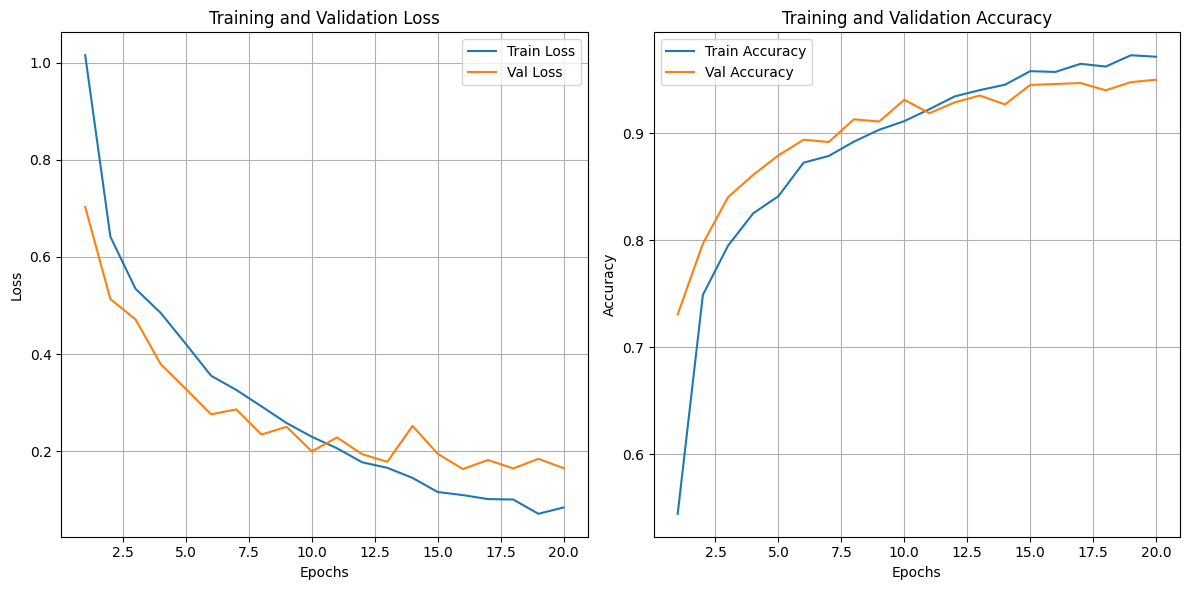

In [41]:
graph_metrics(metrics)

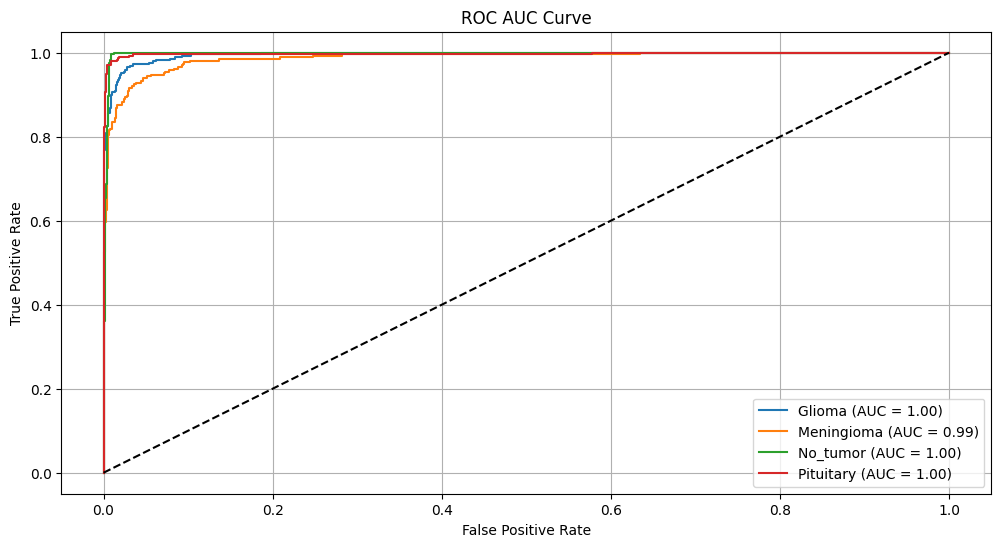

In [42]:
plot_multi_roc_auc(all_labels, all_probs)

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluation(model, test_loader, loss_function, device):
    model.eval()
    metrics = {
        'test_loss': [],
        'test_accuracy': [],
    }

    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)

            preds = model(img)

            loss = loss_function(preds, label)

            metrics['test_loss'].append(loss.item())
            metrics['test_accuracy'].append((preds.argmax(1) == label).float().mean().item())

            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    test_loss = np.mean(metrics['test_loss'])
    test_accuracy = np.mean(metrics['test_accuracy'])

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    # Add tumor labs to x and y axis
    plt.xticks(np.arange(4) + 0.5, ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
    plt.yticks(np.arange(4) + 0.5, ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
    plt.show()

Test Loss: 0.1673, Test Accuracy: 0.9466
Confusion Matrix:
[[290   8   0   2]
 [ 14 251  30  11]
 [  4   0 401   0]
 [  0   1   0 299]]


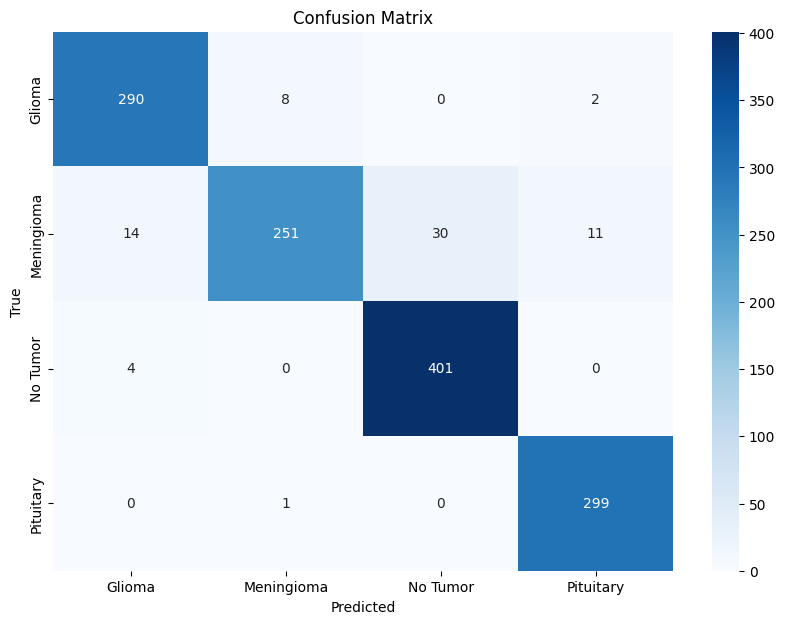

In [44]:
evaluation(model, test_loader, loss_function, device)